# Single-Cell RNA-seq のデータをPythonで解析してみる

## その２　教師あり学習

教師あり学習を簡潔に。  
Pythonによる教師あり学習については膨大な資料がウェブ上にあるので、興味ある方は適当に検索すればいくらでも情報が手に入ります。  
ここではランダムフォレストをさくっとやってみる。  
また、近年活発に研究されている「機械学習の解釈可能性（Interpretability）」、「説明可能（Explainable）AI」などをちょろっとだけ解説する。  

後半の部分は[PyData NYC 2018: Introduction to Model Interpretability](https://github.com/klemag/pydata_nyc2018-intro-to-model-interpretability) を参考に生物学データ向けに再構成。  

解析に使ったデータセットは、  [この論文](https://genomebiology.biomedcentral.com/track/pdf/10.1186/s13059-019-1795-z) の[データ](https://zenodo.org/record/2877646#.XZnjty3APUJ) より再構成。

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi']= 300
sns.set(style='whitegrid')

print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sns.__version__)

1.16.5
0.24.2
3.0.3
0.9.0


## データの前処理

使いやすいかたちに整形してくれているテーブルがあるので、そのまま読み込む。

In [9]:
!git clone https://github.com/genome-sci/pags_workshop_2019.git

Cloning into 'pags_workshop_2019'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 242 (delta 32), reused 45 (delta 16), pack-reused 169
Receiving objects: 100% (242/242), 96.14 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [10]:
import os

infile = 'pags_workshop_2019/3-1/data_sc2/scRNAseq_Benchmark_datasets/Pancreatic_data/Baron_Mouse/Filtered_MousePancreas_data.csv'
df = pd.read_csv(infile, index_col=0)
print(df.shape)

(1886, 14861)


In [11]:
labels_file = 'pags_workshop_2019/3-1/data_sc2/scRNAseq_Benchmark_datasets/Pancreatic_data/Baron_Mouse/Labels.csv'
labels = pd.read_csv(labels_file, skiprows=1, names=['CellType'])
labels = labels.set_index(df.index)
labels['CellType'].value_counts()

beta                  894
ductal                275
delta                 218
alpha                 191
endothelial           139
quiescent_stellate     47
gamma                  41
macrophage             36
activated_stellate     14
B_cell                 10
immune_other            8
T_cell                  7
schwann                 6
Name: CellType, dtype: int64

上の図はデータセットの[元論文](https://www.cell.com/fulltext/S2405-4712(16)30266-6)より引用。  

Baron, Maayan, et al.  
"A single-cell transcriptomic map of the human and mouse pancreas reveals inter-and intra-cell population structure."   
Cell systems 3.4 (2016): 346-360.  
  
  
今回は、該当する細胞数が100以下のcell typeは扱わないことにする。  
以下のようにして、'beta', 'ductal', 'delta', 'alpha', 'endotherial' 以外のcellを除く。

In [12]:
print('Before: ',df.shape)
valid_indices = np.where(labels['CellType'].isin(['beta', 'ductal', 'delta', 'alpha', 'endothelial']))[0]
df = df.iloc[valid_indices, :]
print('After: ',df.shape)

Before:  (1886, 14861)
After:  (1717, 14861)


In [0]:
labels = labels.loc[df.index, :]

いくつか、前回と同じようにしてデータのクオリティチェックと前処理をする。

In [14]:
# すべてのcellで発現量ゼロの遺伝子を削除
df = df.drop(df.columns[df.values.sum(axis=0) == 0.0], axis=1)
print('Total', len(df.columns), 'genes')

Total 14662 genes


In [15]:
print(len(df), 'cells,', len(df.columns), 'genes')
nreads = df.values.sum(axis=1)
ngenes = (df.values > 0.0).astype(int).sum(axis=1)
print('Stats for assigned reads: max=', np.max(nreads), 'min=', np.min(nreads), 'average={:.2f}'.format(np.average(nreads)))
print('Stats for detected genes: max=', np.max(ngenes), 'min=', np.min(ngenes), 'average={:.2f}'.format(np.average(ngenes)))

1717 cells, 14662 genes
Stats for assigned reads: max= 22854 min= 1013 average=5081.14
Stats for detected genes: max= 4552 min= 739 average=1653.76


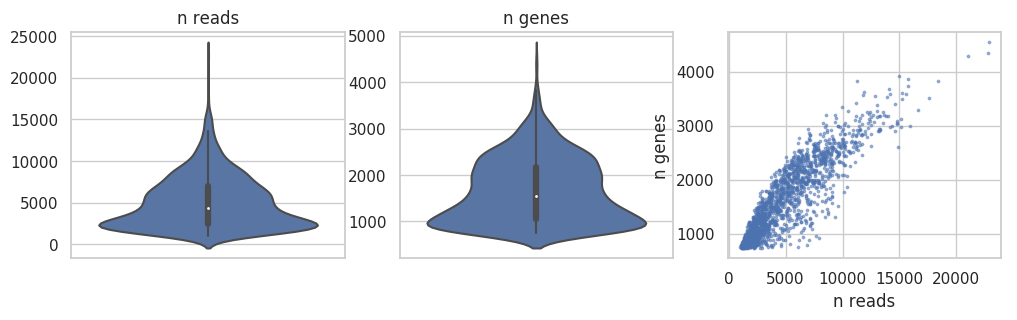

In [17]:
matplotlib.rcParams['figure.dpi']= 100
fig = plt.figure(figsize=(12,3))
ax1 = plt.subplot(1, 3, 1)
sns.violinplot(x=nreads, orient='v', ax=ax1).set_title('n reads')
ax2 = plt.subplot(1, 3, 2)
sns.violinplot(x=ngenes, orient='v', ax=ax2).set_title('n genes')
ax3 = plt.subplot(1, 3, 3)
ax3.scatter(nreads, ngenes, s=3, alpha=.5)
ax3.set_xlabel('n reads')
ax3.set_ylabel('n genes')
plt.show()

クオリティフィルタリングがなされているデータっぽいので、このまま扱う。

In [0]:
# 単純な万分率で正規化。
normalized = 10000 * df.values / df.values.sum(axis=1)[:, np.newaxis]
lognormalized = np.log1p(normalized)
df_lognormalized = pd.DataFrame(lognormalized, index=df.index, columns=df.columns)

前回同様、簡単のため変動の大きい遺伝子のみ使う。

Dispersion  AverageExpr
Gcg        7.690295     5.652270
Sst        7.290901     5.269373
Ins2       7.017776     7.163253
Glycam1    6.481371     0.323414
Ins1       6.444412     6.404533
Ppy        6.293812     3.450690
Pyy        6.131058     4.311266
Iapp       5.415717     5.628391
Dmbt1      5.399320     1.390300
Ttr        5.385128     3.068921

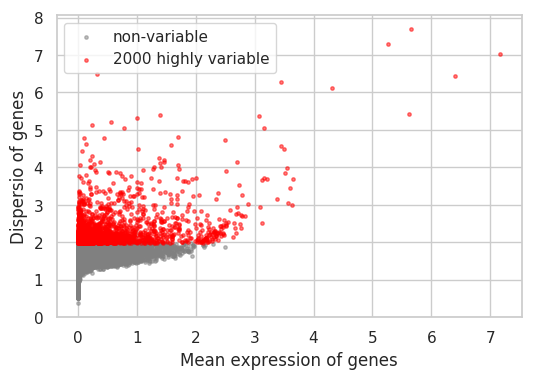

In [19]:
n_highly_variable = 2000
mean = np.expm1(df_lognormalized.values).mean(axis=0)
mean[mean == 0] = 1e-12
dispersion = np.expm1(df_lognormalized.values).var(axis=0, ddof=1) / mean  
dispersion[dispersion == 0] = np.nan
genes = pd.DataFrame(np.log1p(dispersion), index=df_lognormalized.columns, columns=['Dispersion'])
genes['AverageExpr'] = np.log1p(mean)
highly_variable_genes =genes.sort_values(by=['Dispersion'], ascending=False).head(n_highly_variable).index
display(genes.loc[highly_variable_genes, :].head(10))
isHVG = genes.index.isin(highly_variable_genes)
fig, ax = plt.subplots()
ax.scatter(genes.loc[~isHVG, 'AverageExpr'], genes.loc[~isHVG, 'Dispersion'], c='gray', s=6, alpha=.5, label='non-variable')
ax.scatter(genes.loc[isHVG, 'AverageExpr'], genes.loc[isHVG, 'Dispersion'], c='red', s=6, alpha=.5, label='{} highly variable'.format(n_highly_variable))
ax.set_xlabel('Mean expression of genes')
ax.set_ylabel('Dispersio of genes')
plt.legend()
plt.show()

In [20]:
# 正規化テーブルから、highly variable genesの項目のみ抽出
df_HVGs = df_lognormalized.loc[:, isHVG]
print(df_HVGs.shape)

(1717, 2000)


主成分分析でデータ全体を眺めてみる。

In [0]:
# 平均0, 分散1に標準化する
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_HVGs.values)
scaled_values = np.clip(scaled_values, None, 10)
df_scaled = pd.DataFrame(scaled_values, index=df_HVGs.index, columns=df_HVGs.columns)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_scaled.values)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
x = pca.transform(df_scaled.values)

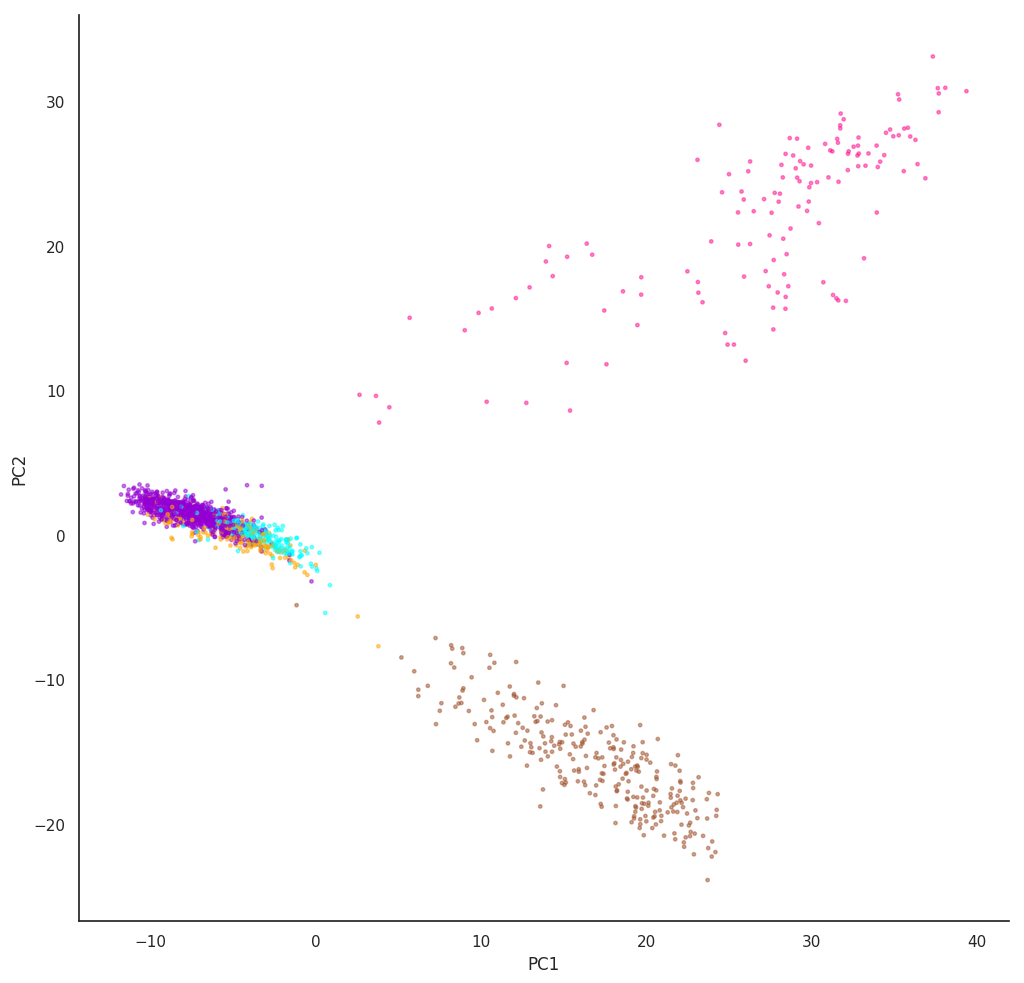

In [24]:
sns.set(style='white')
color_dict = {'beta': 'darkviolet', 
    'ductal': 'sienna', 
    'delta': 'orange',
    'alpha': 'cyan',
    'endothelial': 'deeppink'}

colors = [color_dict[c] for c in labels['CellType']]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(x[:, 0], x[:, 1], s=6, color=colors, alpha=.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
sns.despine()
plt.show()

'endothelical' と 'ductal' は明確に異なるが、'alpha', 'beta', 'delta'細胞はPCAで見ると違いがあまりよくわからない。

In [25]:
!pip install umap-learn
import umap
umap_model = umap.UMAP(n_components=2, \
                       n_neighbors=30, min_dist=0.3, metric='cosine',  \
                       random_state=42, verbose=False)
umap_coords = umap_model.fit_transform(df_scaled.values)

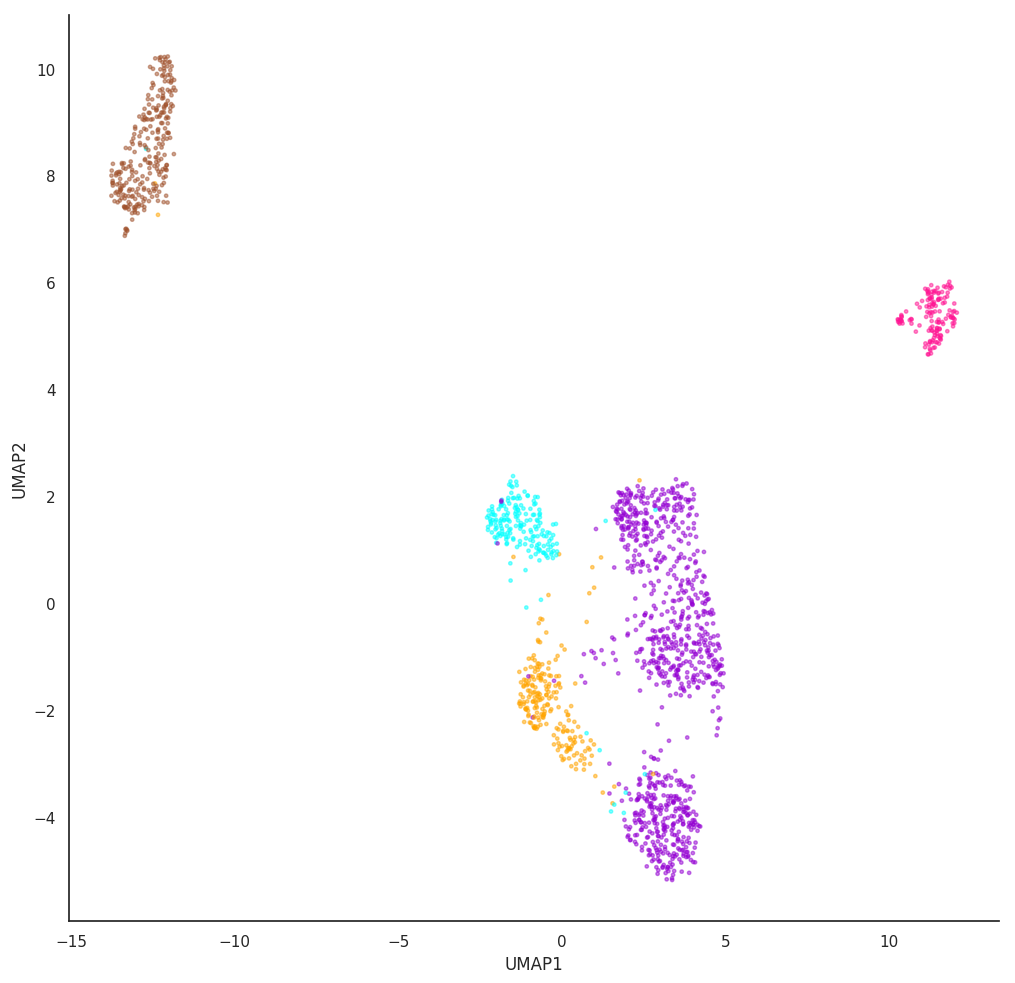

In [26]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, color=colors, alpha=.5)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
sns.despine()
plt.show()

UMAPで見ると、それぞれわりと違ったパターンなことがわかる。

## 決定木による分類器の学習

決定木を使って、遺伝子発現パターンから5つの細胞クラスを分類するモデルを学習してみる。  

※教師あり学習の題材として適切なデータセットではない。そもそも正解ラベル分類が遺伝子発現パターンに依存している。あくまで、一連の流れを確認してみるだけ。  

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier

In [28]:
X = df_HVGs
y = labels['CellType']
print(X.shape)
print(y.shape)

(1717, 2000)
(1717,)


モデルの設定。

In [0]:
dt_model = DecisionTreeClassifier(criterion='gini', class_weight='balanced')

トレーニングデータ、テストデータの分割。データ全体の30%をテストデータとする。  
また、予測ラベル（細胞クラス）の割合がトレーニングデータとテストデータで同じになるようにする。

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array(['alpha', 'beta', 'delta', 'ductal', 'endothelial'], dtype=object), array([134, 625, 153, 192,  97]))
(array(['alpha', 'beta', 'delta', 'ductal', 'endothelial'], dtype=object), array([ 57, 269,  65,  83,  42]))


モデルのハイパーパラメータをグリッドサーチ。

In [31]:
gs = GridSearchCV(dt_model, {"max_depth": [3, 4, 5], 
                             "min_samples_split": [5, 10]}, 
                  n_jobs=-1, cv=5, scoring="accuracy")
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'min_samples_split': [5, 10]},
             pre_dispatch='2*n_jobs', refit=True, re

In [32]:
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 5, 'min_samples_split': 5}
0.9542048293089093


In [33]:
dt_model.set_params(**gs.best_params_, random_state=42)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [34]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [0]:
y_pred = dt_model.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.9670542635658915

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       alpha       0.93      0.91      0.92        57
        beta       0.99      0.98      0.99       269
       delta       0.93      0.95      0.94        65
      ductal       0.94      0.98      0.96        83
 endothelial       1.00      0.95      0.98        42

    accuracy                           0.97       516
   macro avg       0.96      0.96      0.96       516
weighted avg       0.97      0.97      0.97       516



このデータセットの中だけで見た場合、決定木だけでも精度は非常に高い。
alpha細胞とdelta細胞で少しミスってるので、どんなふうに予測ミスしているのかをみてみる。

In [38]:
missed = y_test.values != y_pred
missed_indices = [df_scaled.index.get_loc(x) for x in y_test[y_test.values != y_pred].index]
missed_data = pd.DataFrame(missed_indices, columns=['ind'])
missed_data['Truth'] = y_test[missed].values
missed_data['Predicted'] = y_pred[missed]
missed_data['CellID'] =  y_test[y_test.values != y_pred].index
display(missed_data)

ind        Truth Predicted                       CellID
0   1135       ductal     delta  mouse2_lib2.final_cell_0108
1    625        delta     alpha  mouse1_lib3.final_cell_0123
2    485        alpha      beta  mouse1_lib2.final_cell_0261
3    145       ductal     alpha  mouse1_lib1.final_cell_0159
4    351         beta     delta  mouse1_lib2.final_cell_0111
5   1316         beta    ductal  mouse2_lib2.final_cell_0307
6   1658        alpha      beta  mouse2_lib3.final_cell_0330
7    594        delta     alpha  mouse1_lib3.final_cell_0088
8   1676        alpha     delta  mouse2_lib3.final_cell_0349
9    998  endothelial    ductal  mouse2_lib1.final_cell_0274
10  1193         beta     delta  mouse2_lib2.final_cell_0168
11   375        delta     alpha  mouse1_lib2.final_cell_0138
12  1194         beta     delta  mouse2_lib2.final_cell_0170
13  1512        alpha    ductal  mouse2_lib3.final_cell_0168
14   959        alpha      beta  mouse2_lib1.final_cell_0230
15   247  endothelial    ductal  mouse1_lib1.final_cell_0275
16  1510         beta    ductal  mouse2_lib3.final_cell_0166

間違えたやつのUMAP上での位置を見てみる。

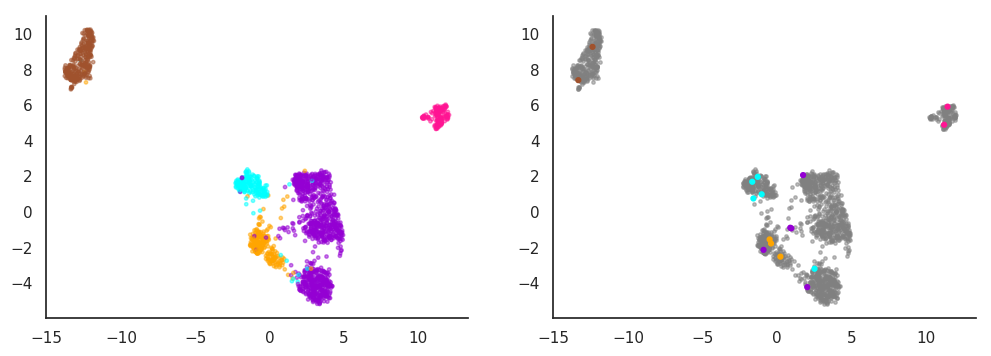

In [39]:
fig = plt.figure(figsize=(12, 4))

colors = [color_dict[c] for c in labels['CellType']]
ax1 = fig.add_subplot(121)
ax1.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, color=colors, alpha=.5)
sns.despine()
background_color = 'gray'
ax2 = fig.add_subplot(122)
ax2.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, color=background_color, alpha=.5)
ax2.scatter(umap_coords[missed_data['ind'], 0], umap_coords[missed_data['ind'], 1], 
            s=12, color=np.array(colors)[missed_data['ind']], alpha=1.)
sns.despine()
plt.show()

## モデルのグローバルな解釈
構築された予測器から、特徴量が予測に与えた影響の度合い（feature importance）を調べてみる。  
決定木の場合によく使われるfeature importance の指標は、Gini importance と呼ばれる指標。  
その特徴によるsplitが、どの程度のGini係数の減少を子ノードに与えたか、それぞれの子ノードのサンプル数で重みづけて計算。

In [40]:
!pip install eli5

     |████████████████████████████████| 112kB 3.5MB/s 


In [41]:
import eli5
eli5.show_weights(dt_model, 
    feature_names=list(df_scaled.columns), target_names=['alpha', 'beta', 'delta', 'ductal', 'endothelial'])

Using TensorFlow backend.


## ランダムフォレストによる分類器の学習

ランダムフォレストを使って、遺伝子発現パターンから5つの細胞クラスを分類するモデルを学習してみる。  

In [0]:
from sklearn.ensemble import RandomForestClassifier

モデルの設定。

In [0]:
rf_model =  RandomForestClassifier(class_weight="balanced", n_estimators=20, n_jobs=1, random_state=42)

In [44]:
gs = GridSearchCV(rf_model, {"max_depth": [3, 4, 5], 
                             "min_samples_split": [5, 10]}, 
                  n_jobs=1, cv=5, scoring="accuracy")
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='w

In [45]:
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 3, 'min_samples_split': 5}
0.9816819317235637


In [46]:
rf_model.set_params(**gs.best_params_, random_state=42)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [47]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
y_pred = rf_model.predict(X_test)

In [49]:
accuracy_score(y_test, y_pred)

0.9922480620155039

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       alpha       0.98      1.00      0.99        57
        beta       1.00      0.99      0.99       269
       delta       0.96      0.98      0.97        65
      ductal       1.00      1.00      1.00        83
 endothelial       1.00      1.00      1.00        42

    accuracy                           0.99       516
   macro avg       0.99      0.99      0.99       516
weighted avg       0.99      0.99      0.99       516



In [51]:
missed = y_test.values != y_pred
missed_indices = [df_scaled.index.get_loc(x) for x in y_test[y_test.values != y_pred].index]
missed_data = pd.DataFrame(missed_indices, columns=['ind'])
missed_data['Truth'] = y_test[missed].values
missed_data['Predicted'] = y_pred[missed]
missed_data['CellID'] =  y_test[y_test.values != y_pred].index
display(missed_data)

ind  Truth Predicted                       CellID
0  1519   beta     delta  mouse2_lib3.final_cell_0176
1  1193   beta     delta  mouse2_lib2.final_cell_0168
2   909  delta     alpha  mouse2_lib1.final_cell_0173
3  1221   beta     delta  mouse2_lib2.final_cell_0197

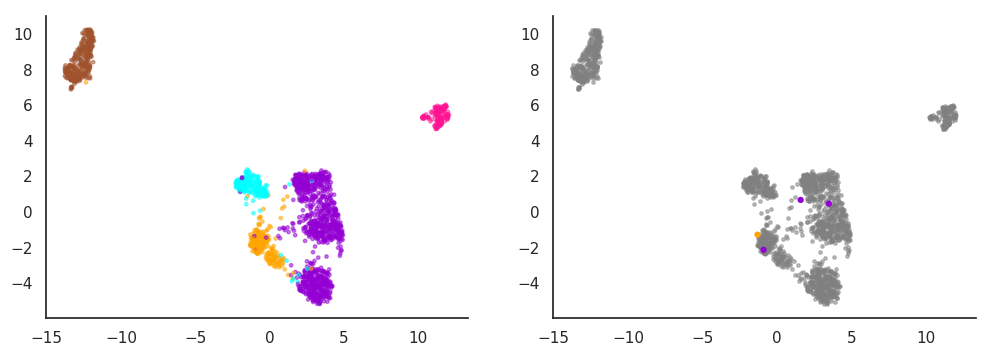

In [52]:
fig = plt.figure(figsize=(12, 4))

colors = [color_dict[c] for c in labels['CellType']]
ax1 = fig.add_subplot(121)
ax1.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, color=colors, alpha=.5)
sns.despine()
background_color = 'gray'
ax2 = fig.add_subplot(122)
ax2.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, color=background_color, alpha=.5)
ax2.scatter(umap_coords[missed_data['ind'], 0], umap_coords[missed_data['ind'], 1], 
            s=12, color=np.array(colors)[missed_data['ind']], alpha=1.)
sns.despine()
plt.show()

feature importanceを計算してみる。

Random forestの場合もよく使われるのは、Gini Importance / Mean Decrease in Impurity (MDI)  と呼ばれている指標。  
決定木と違って木がたくさんあるので、生成した決定木それぞれで計算して、全体を平均する。  
rf_model.feature_importances_ でもアクセスできる。

In [53]:
import eli5
eli5.show_weights(rf_model, feature_names=list(df_scaled.columns))

これも有名な指標。  
Permutation importance と呼ばれていて、ランダムフォレストに限らず様々な予測モデルで特徴量の重要性を計算できる。(Model agnostic)  
ただ、特徴量の数が多いとめちゃくちゃ計算時間がかかるので注意。

In [54]:
"""
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=list(df_scaled.columns))
"""

'\nfrom eli5.sklearn import PermutationImportance\n\nperm = PermutationImportance(rf_model).fit(X_test, y_test)\neli5.show_weights(perm, feature_names=list(df_scaled.columns))\n'

##advanced: モデルの局所的な解釈

### 1.LIME (Local Interpretable Model-agnostic Explanations)

In [55]:
!pip install lime

     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=320acaac5e84bb113b0e2b4dd3560333edb5beb64a007f2e7a071f0df06a034e
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
from lime.lime_tabular import LimeTabularExplainer

In [0]:
classes = ['alpha', 'beta', 'delta', 'ductal', 'endothelial']

In [0]:
explainer = LimeTabularExplainer(X_train.values,
                                 mode="classification",
                                 feature_names=X_train.columns.tolist(),
                                 class_names=classes,
                                 random_state=42)

In [59]:
missed_cells = missed_data['CellID'].values
observations = X_test.loc[missed_cells, :].values

print(f"""\
* True label: {missed_data['Truth'].values}
* Pred label: {rf_model.predict(observations)}
* RF: {rf_model.predict_proba(observations)}
""")

* True label: ['beta' 'beta' 'delta' 'beta']
* Pred label: ['delta' 'delta' 'alpha' 'delta']
* RF: [[0.1327453  0.36385463 0.38551684 0.08412044 0.03376279]
 [0.19909867 0.2709235  0.36399303 0.1236507  0.04233409]
 [0.45023826 0.16298923 0.26937773 0.07098475 0.04641003]
 [0.28090101 0.24228486 0.38613792 0.05549023 0.03518598]]



In [0]:
explanation = explainer.explain_instance(observations[0], 
    rf_model.predict_proba, num_features=5, top_labels=1)

In [61]:
explanation.show_in_notebook(show_table=True, show_all=False)

In [62]:
explanation = explainer.explain_instance(observations[1], 
    rf_model.predict_proba, num_features=5, top_labels=1)
explanation.show_in_notebook(show_table=True, show_all=False)

In [63]:
explanation = explainer.explain_instance(observations[2], 
    rf_model.predict_proba, num_features=5, top_labels=1)
explanation.show_in_notebook(show_table=True, show_all=False)

In [64]:
explanation = explainer.explain_instance(observations[3], 
    rf_model.predict_proba, num_features=5, top_labels=1)
explanation.show_in_notebook(show_table=True, show_all=False)

### 2.SHAP (SHapley Additive exPlanations)

In [65]:
!pip install shap

     |████████████████████████████████| 245kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.30.2-cp36-cp36m-linux_x86_64.whl size=360638 sha256=6c09dabb4fb1ab103533f9c7bed3e274a99a2d37f25aadc0c7e795313cea6170
  Stored in directory: /root/.cache/pip/wheels/97/46/c9/b9dc708249af7eaf0951b2be62e0f6191f4de385a48e1a4cb7
Successfully built shap


In [66]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

In [0]:
explainer = shap.TreeExplainer(rf_model)

In [68]:
shap_values = explainer.shap_values(observations)
print(len(shap_values))
print(shap_values[0].shape)

5
(4, 2000)


In [69]:
explainer.expected_value

[0.20253648720061018,
 0.20498030268756448,
 0.1992398759026629,
 0.2012734553887104,
 0.19196987882045208]

In [71]:
shap.initjs() 
i = 0
for class_id in range(5):
    print(classes[class_id])
    display(shap.force_plot(explainer.expected_value[class_id], shap_values[class_id][i,:], 
                    features=observations[i, :], feature_names=X_train.columns.tolist()))

alpha


beta


delta


ductal


endothelial
